# Eval Visualization of Pendulum-v1

Action space: Box(-2.0, 2.0, (1,), float32)
Observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Device: cpu | Environment: <TimeLimit<OrderEnforcing<PassiveEnvChecker<PendulumEnv<Pendulum-v1>>>>>
GIF saved to ./demo.gif


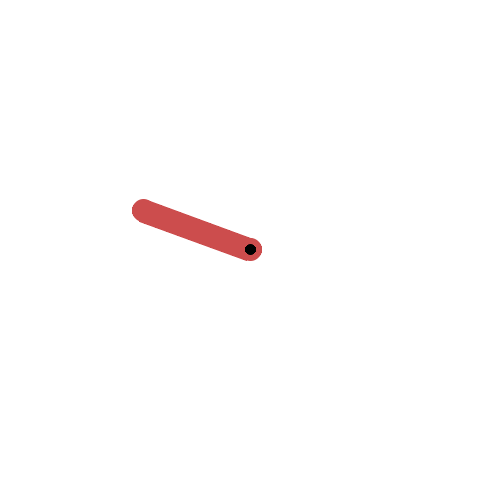

Evaluating: 100%|██████████| 100/100 [00:01<00:00, 58.44it/s]



Evaluation complete!
Average return over 100 episodes: -193.51 (std: 147.05)
Final score: -340.56

EXCELLENT! Beat PPO baseline
Grade: 50.00% out of 50%
🌟 CONGRATULATIONS! you did great! 🌟


In [3]:
import argparse
import importlib
import numpy as np
import gymnasium as gym
from tqdm import tqdm

class Args:
    def __init__(self):
        self.episodes = 100
        self.record_demo = True

def parse_arguments():
    parser = argparse.ArgumentParser(description="DRL HW4 Q1 - Pendulum-v1")
    parser.add_argument("--episodes", default=100, type=int, help="Number of episodes to evaluate")
    parser.add_argument("--record_demo", action="store_true", help="Record a demonstration")
    return parser.parse_args()

def load_agent(agent_path):
    """Dynamically load the student's agent class"""
    spec = importlib.util.spec_from_file_location("student_agent", agent_path)
    student_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(student_module)
    return student_module.Agent()

def record_video(env, agent):
    import imageio
    gif_path = f'./demo.gif'

    state, info = env.reset()
    frames = []

    while True:
        frame = env.render()
        frames.append(np.array(frame))
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        state = next_state

        if terminated or truncated:
            break

    imageio.mimsave(gif_path, frames, fps=30)
    print(f'GIF saved to {gif_path}')

    from IPython.display import Image, display
    display(Image(gif_path))

def make_env():
    # Create Pendulum-v1 environment
    env = gym.make("Pendulum-v1", render_mode='rgb_array')
    return env

def eval_score():
    """Evaluate the agent's performance on Pendulum-v1"""
    args = Args()

    
    env = make_env()
    print(f"Action space: {env.action_space}")
    print(f"Observation space: {env.observation_space}")
    
    # Load student's agent
    agent = load_agent("student_agent.py")
    
    if args.record_demo:
        record_video(env, agent)

    # Run evaluation
    episode_rewards = []
    
    for episode in tqdm(range(args.episodes), desc="Evaluating"):
        observation, info = env.reset(seed=np.random.randint(0, 1000000))
        
        episode_reward = 0
        done = False
        step = 0
        
        
        while not done:
            
            # Get action from student's agent
            action = agent.act(observation)
            
            # Step the environment
            observation, reward, terminated, truncated, info = env.step(action)
            
            episode_reward += reward
            done = terminated or truncated
            step += 1
            
        episode_rewards.append(episode_reward)
    
    env.close()
    
    # Calculate final score
    mean = np.mean(episode_rewards)
    std = np.std(episode_rewards)
    print(f"\nEvaluation complete!")
    print(f"Average return over {args.episodes} episodes: {mean:.2f} (std: {std:.2f})")
    print(f"Final score: {mean - std:.2f}")
    
    return np.round(mean - std, 2)

score = eval_score()
# Pendulum-v1 has negative rewards, so good performance is closer to 0
# Typical random policy scores around -1000 to -1500
# Define the baselines
RANDOM_SCORE = -1600
PPO_SCORE = -400

# Calculate grade percentage according to provided rules
grade_percentage = 0

if score >= PPO_SCORE:
    # Beat PPO baseline
    grade_percentage = 50
    result = "EXCELLENT! Beat PPO baseline"
elif score >= RANDOM_SCORE:
    # Beat Random but not PPO
    # Normalize score between random and PPO
    normalized_score = (score - RANDOM_SCORE) / (PPO_SCORE - RANDOM_SCORE)
    grade_percentage = 10 + normalized_score * 40
    result = "GOOD! Beat Random baseline but not PPO"
else:
    # Did not beat Random
    grade_percentage = 0
    result = "DID NOT meet the Random baseline"

print(f"\n{result}")
print(f"Grade: {grade_percentage:.2f}% out of 50%")
if grade_percentage >= 50:
    print("\033[92m🌟 CONGRATULATIONS! you did great! 🌟\033[0m")
elif grade_percentage > 0:
    print(f"\033[93mYou earned {grade_percentage:.2f}% out of 50%.\033[0m")
else:
    print("\033[91mUnfortunately, you did not pass the evaluation.\033[0m")
